In [44]:
#your name: Cherif.  Dezons
#your student number: .....  ....


import numpy as np


#Question 1
#J = np.random.randint(5000)
#K = np.random.randint(5000)
J = 20000
K = 5000
num_samples = J + K

# draw random numbers for every feature
x_1 = np.random.uniform(low=18., high=80., size=(num_samples, 1))              
x_2 = np.random.uniform(low=1., high=15., size=(num_samples, 1))                
x_3 = np.float32(np.random.uniform(low=0., high=1., size=(num_samples, 1)) < .1)
X = np.concatenate([x_1, x_2, x_3], axis=1)
X_J = X[:J, :]

# means 
Mean_J = np.mean(X_J, axis=0)
print('Empirical mean: age = ' + str(Mean_J[0]))
print('Empirical mean: monthly income in CHF 1000 = ' + str(Mean_J[1]))
print('Empirical mean: self-employed indicator = ' + str(Mean_J[2]))    


Empirical mean: age = 49.17231340212181
Empirical mean: monthly income in CHF 1000 = 8.01899529753286
Empirical mean: self-employed indicator = 0.09895


In [45]:
# EXERCISE 2
sigmoid = lambda x: 1. / (1. + np.exp(-x))

#Linear model

# Model parameters 
a_0 = -10
a_1 = 3
a_2 = -7
a_3 = 15

p_x = sigmoid(a_0 + a_1 * np.sqrt(np.absolute(x_1 - 55)) + a_2 * x_2 + a_3 * x_3)
y = np.float32(np.squeeze(np.random.uniform(size=(num_samples, 1)) < p_x))
print("Default rate {:.2f}%".format(np.mean(y[:J]) * 100.))


Default rate 0.99%


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

#Non linear model 

X_train = X[:J, :]
X_test = X[J:, :]
y_train = y[:J]
y_test = y[J:]
p_test = p_x[J:]

# logitic regression
model_LR = LogisticRegression().fit(X_train, y_train)

#scores 
scores_LR_train = model_LR.predict_proba(X_train)
scores_LR = model_LR.predict_proba(X_test)
# total deviance

print('total deviance for training data = ' + str(log_loss(y_train, scores_LR_train[:, 1])))
print('total deviance for test data = ' + str(log_loss(y_test, scores_LR[:, 1])))

total deviance for training data = 0.01208949833206525
total deviance for test data = 0.009281194635954304


In [47]:
# Fraction of ones 
comp_LR = np.stack((scores_LR[:,1], y_test), axis=-1)
select = (comp_LR[:, 0] <= 0.04) & (comp_LR[:, 0] >= 0.03)
comp_LR_select = comp_LR[select, :]
print('fraction of y_j=1: ' + str( np.mean(comp_LR_select[:,1]) ) )

fraction of y_j=1: 0.0


In [48]:
# Neural network

# Create and train neural network

import tensorflow as tf
from tensorflow import keras 

#build the nn model with 2 hidden layers
model_NN = keras.Sequential(
    [
     keras.layers.BatchNormalization(),
     keras.layers.Dense(32, activation='relu', name="hidden_layer_1"),
     keras.layers.Dense(32, activation='relu', name="hidden_layer_2"),
     keras.layers.Dense(1, activation='sigmoid', name="output_layer")
    ]
)

#the loss function
def total_deviance(y_true, y_pred):
    return tf.math.reduce_mean(-y_true * tf.math.log(y_pred) - (1. - y_true) * tf.math.log(1. - y_pred))

#pick an optimizer
model_NN.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=total_deviance
)

#shuffle the data during training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, np.float32(y_train)))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(256)

#fit the model
model_NN.fit(
    train_dataset,
    batch_size=256,
    epochs=10
)



Epoch 1/10
79/79 [==============================] - 0s 944us/step - loss: 0.2266
Epoch 2/10
79/79 [==============================] - 0s 856us/step - loss: 0.0495
Epoch 3/10
79/79 [==============================] - 0s 828us/step - loss: 0.0344
Epoch 4/10
79/79 [==============================] - 0s 816us/step - loss: 0.0283
Epoch 5/10
79/79 [==============================] - 0s 843us/step - loss: 0.0245
Epoch 6/10
79/79 [==============================] - 0s 822us/step - loss: 0.0214
Epoch 7/10
79/79 [==============================] - 0s 829us/step - loss: 0.0195
Epoch 8/10
79/79 [==============================] - 0s 841us/step - loss: 0.0177
Epoch 9/10
79/79 [==============================] - 0s 859us/step - loss: 0.0165
Epoch 10/10
79/79 [==============================] - 0s 845us/step - loss: 0.0161


In [49]:
#scores on the test
scores_NN_train = model_NN(X_train)
scores_NN = model_NN(X_test)

print('total deviance for training data = ' + str(log_loss(y_train, scores_NN_train)))
print('total deviance for test data = ' + str(log_loss(y_test, scores_NN)))

total deviance for training data = 0.01433142086749518
total deviance for test data = 0.012356143762047054


In [50]:
# fraction of ones 

comp_NN = np.stack((scores_NN.numpy()[:,0], y_test), axis=-1)
select = (comp_NN[:, 0] <= 0.04) & (comp_NN[:, 0] >= 0.03)
comp_NN_select = comp_NN[select, :]
print('fraction of y_j=1: ' + str( np.mean(comp_NN_select[:,1]) ) )

fraction of y_j=1: 0.028571429


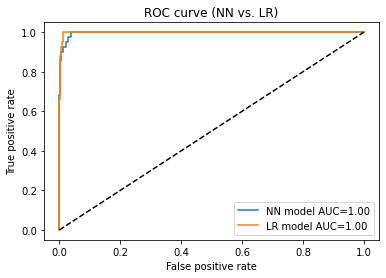

In [51]:
# Plot of the ROC curve
from sklearn.metrics import roc_auc_score

fpr_LR, tpr_LR, thresholds_LR = metrics.roc_curve(y_test, scores_LR[:, 1], pos_label=1)
auc_LR = roc_auc_score(y_test, scores_LR[:, 1])
fpr_NN, tpr_NN, thresholds_NN = metrics.roc_curve(y_test, scores_NN[:, 0], pos_label=1)
auc_NN = roc_auc_score(y_test, scores_NN[:, 0])

plt.plot(fpr_NN, tpr_NN, label='NN model AUC={:.2f}'.format(auc_NN))
plt.plot(fpr_LR, tpr_LR, label='LR model AUC={:.2f}'.format(auc_LR))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (NN vs. LR)')
plt.legend(loc='best')

0.08151039015819711


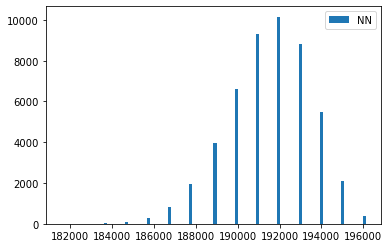

In [54]:
# EXERCISE 3

# Expected P &L

from scipy.stats import norm
import matplotlib as mpl

portfolio_size = K  
rate = 0.04 
loan_amount = 1000

defaults = np.float32(np.random.uniform(low=0., high=1., size=(portfolio_size, 50000)) < p_test[:portfolio_size, :])  # select last K samples, which form the 'test' dataset
defaultR_ins = np.mean(y[:J])
threshold = np.quantile(scores_NN_train, 1.-2*defaultR_ins)
# threshold = 0.2 # To compare to an arbitrary threshold
print(threshold)
p_and_l_NN = np.sum(loan_amount * (rate * (1. - defaults) - defaults) * np.float32(scores_NN < threshold), axis=0)

plt.figure(2)
plt.hist(p_and_l_NN, bins=100, label='NN')
plt.legend()

In [56]:
# PART B
# Compute the 'pct_VaR'%-VaR
pct_VaR=95
index = int(( (100-pct_VaR)*50000/100 )-1)
print('Expected P&L (NN): {:.2f}'.format(np.mean(p_and_l_NN)))

p_and_l_b_NN = np.sort(p_and_l_NN)
print('VaR (NN): {:.2f}'.format(-p_and_l_b_NN[index]))

Expected P&L (NN): 191516.20
VaR (NN): -187800.00


In [57]:
from scipy.optimize import minimize
def to_opt(threshold):
  to_give_a_loan = scores_NN_train.numpy() < threshold
  pred_not_default = to_give_a_loan[to_give_a_loan] * 1 # Looks weird is correct
  # print(pred_not_default.shape)
  true_defaults = y_train[to_give_a_loan[:,0]]
  return np.absolute(np.average((pred_not_default - true_defaults) == 0))

res = minimize(to_opt, np.array(0.12), bounds=((0,1),), method="SLSQP", options={'eps':0.01})
print(res)

     fun: 0.0013228859265289508
     jac: array([-5.38250809e-05])
 message: 'Optimization terminated successfully'
    nfev: 2
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.12])


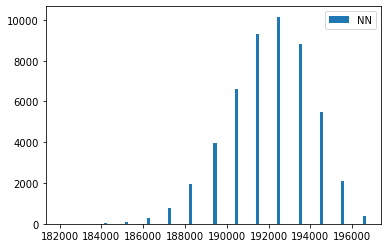

In [58]:
# Rerun the code to for the new threshold
p_and_l_NN = np.sum(loan_amount * (rate * (1. - defaults) - defaults) * np.float32(scores_NN < res.x), axis=0)

plt.figure(2)
plt.hist(p_and_l_NN, bins=100, label='NN')
plt.legend()

In [60]:
# Compute the 'pct_VaR'%-VaR
pct_VaR=95
index = int(( (100-pct_VaR)*50000/100 )-1)
print('Expected P&L (NN): {:.2f}'.format(np.mean(p_and_l_NN)))

p_and_l_b_NN = np.sort(p_and_l_NN)
print('VaR (NN): {:.2f}'.format(-p_and_l_b_NN[index]))



Expected P&L (NN): 192035.84
VaR (NN): -188320.00
